In [1]:
import os
import pathlib
import opensmile

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers.experimental import preprocessing

import matplotlib.pyplot as plt

In [2]:
# James
data_path = '/tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train' # change this 

# Michael
# data_path = '/tf/data/ADReSS-IS2020' # change this 
audio_path_cc = data_path + '/Full_wave_enhanced_audio/cc/'
audio_path_cd = data_path + '/Full_wave_enhanced_audio/cd/'


text_path_cc = data_path + '/transcription/cc/'
text_path_cd = data_path + '/transcription/cd/'

In [3]:
meta_cc = pd.read_csv(data_path + '/cc_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])
meta_cd = pd.read_csv(data_path + '/cd_meta_data.txt', sep=";", header=0, 
                      names = ['ID', 'Age', 'Gender', 'MMSE'])

meta = meta_cc.assign(Group = 'cc').append(meta_cd.assign(Group = 'cd')).reset_index()

In [4]:
meta["ID"] = meta["ID"].str.strip()

In [5]:
ad_files = [str(f) for f in pathlib.Path(audio_path_cd).glob('*.wav')]
control_files = [str(f) for f in pathlib.Path(audio_path_cc).glob('*.wav')]

In [6]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.ComParE_2016,
    feature_level=opensmile.FeatureLevel.Functionals,
)

In [7]:
ad_data = smile.process_files(ad_files)
control_data = smile.process_files(control_files)

In [8]:
def add_MMSE(data):
    data.reset_index(inplace=True)
    data["filename"] = data["file"].str.split("/").str[-1].str.split('.wav').str[0]
    data = data.merge(meta[["ID", "MMSE"]], how="inner", left_on="filename", right_on="ID").drop(["ID","filename"], axis=1)
    data.set_index(["file","start","end"], inplace=True)
    return data

ad_data = add_MMSE(ad_data)
control_data = add_MMSE(control_data)

In [9]:
data = pd.concat([ad_data,control_data])

In [10]:
data = data.sample(frac=1)

In [11]:
data = data[data["MMSE"]!=' NA']
data["MMSE"] = data["MMSE"].astype(float)

In [12]:
data

,,,audspec_lengthL1norm_sma_range,audspec_lengthL1norm_sma_maxPos,audspec_lengthL1norm_sma_minPos,audspec_lengthL1norm_sma_quartile1,audspec_lengthL1norm_sma_quartile2,audspec_lengthL1norm_sma_quartile3,audspec_lengthL1norm_sma_iqr1-2,audspec_lengthL1norm_sma_iqr2-3,audspec_lengthL1norm_sma_iqr1-3,audspec_lengthL1norm_sma_percentile1.0,...,mfcc_sma_de[14]_peakRangeRel,mfcc_sma_de[14]_peakMeanAbs,mfcc_sma_de[14]_peakMeanMeanDist,mfcc_sma_de[14]_peakMeanRel,mfcc_sma_de[14]_minRangeRel,mfcc_sma_de[14]_meanRisingSlope,mfcc_sma_de[14]_stddevRisingSlope,mfcc_sma_de[14]_meanFallingSlope,mfcc_sma_de[14]_stddevFallingSlope,MMSE
file,start,end,,,,,,,,,,,,,,,,,,,,,
/tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/S128.wav,0 days,0 days 00:00:51.742607710,3.054678,0.022644,0.274627,0.027386,0.170253,0.834941,0.142868,0.664687,0.807555,0.022171,...,0.600708,2.818464,2.820660,-19.999981,0.479517,120.031296,78.115494,116.632103,76.175949,16.0
/tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/S153.wav,0 days,0 days 00:01:09.894580499,3.529114,0.231023,0.000000,0.100103,0.319241,0.863473,0.219138,0.544232,0.763370,0.039520,...,0.577708,3.575543,3.578871,-19.999935,0.641939,155.716507,95.372932,155.103699,90.477089,12.0
/tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/S114.wav,0 days,0 days 00:00:29.462789116,3.471463,0.002722,0.707724,0.123342,0.383634,0.713696,0.260292,0.330062,0.590354,0.023989,...,0.429051,3.105199,3.109642,-19.999184,0.713346,132.788635,76.333969,132.038406,78.903870,16.0
/tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/S122.wav,0 days,0 days 00:00:44.796371882,1.021077,0.944991,0.876118,0.020083,0.134135,0.295344,0.114052,0.161209,0.275262,0.010027,...,0.559167,2.828944,2.825503,19.999668,0.562144,110.187218,64.986427,111.316254,66.798546,17.0
/tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/S118.wav,0 days,0 days 00:01:48.615827664,5.451656,0.009121,0.317118,0.114940,0.346554,0.796292,0.231614,0.449738,0.681351,0.041442,...,0.685619,3.775789,3.773688,20.000000,0.620358,157.185074,85.800171,162.963943,90.601967,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/S087.wav,0 days,0 days 00:02:06.633378685,1.533435,0.024178,0.125316,0.016433,0.019892,0.096028,0.003459,0.076136,0.079595,0.014337,...,0.592506,2.603791,2.603075,20.000000,0.505170,111.989395,68.541687,116.006996,71.263458,7.0
/tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/S151.wav,0 days,0 days 00:00:28.807006803,3.575012,0.456666,0.414897,0.155500,0.462538,1.094966,0.307038,0.632428,0.939466,0.055454,...,0.533482,4.125591,4.123552,20.000000,0.489023,176.703674,105.648964,168.833618,107.713348,24.0
/tf/dementia/0extra/ADReSS-IS2020-train/ADReSS-IS2020-data/train/Full_wave_enhanced_audio/cd/S148.wav,0 days,0 days 00:00:35.260272108,3.156870,0.038932,0.000000,0.025819,0.227520,1.093325,0.201701,0.865806,1.067507,0.021633,...,0.607132,2.653949,2.655147,-20.000000,0.518383,118.128296,68.479431,106.055832,59.064877,17.0


In [13]:
train_cutoff = int(len(data)*0.7)
val_cutoff = int(len(data)*0.85)

train = data[:train_cutoff]
val = data[train_cutoff:val_cutoff]
test = data[val_cutoff:]

train_x = train.drop("MMSE", axis=1).to_numpy()
train_y = train["MMSE"].to_numpy()

val_x = val.drop("MMSE", axis=1).to_numpy()
val_y = val["MMSE"].to_numpy()

test_x = test.drop("MMSE", axis=1).to_numpy()
test_y = test["MMSE"].to_numpy()

In [14]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_x)

model = models.Sequential([
    layers.Input(shape=(6373,)),
    norm_layer,
    layers.Dense(2056, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='relu')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 6373)              12747     
_________________________________________________________________
dense (Dense)                (None, 2056)              13104944  
_________________________________________________________________
dropout (Dropout)            (None, 2056)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1053184   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [15]:
model.compile(
    optimizer="adam",
    loss='mse',
    metrics=[tf.keras.losses.MeanSquaredError()]
)

In [16]:
EPOCHS = 100
history = model.fit(
    train_x,
    train_y,
    batch_size=64,
    epochs=EPOCHS,
    validation_data=(val_x, val_y)
)

Epoch 1/100
2/2 [==============================] - 3s 922ms/step - loss: 501.5660 - mean_squared_error: 491.3708 - val_loss: 54252.5430 - val_mean_squared_error: 54252.5430
Epoch 2/100
2/2 [==============================] - 1s 285ms/step - loss: 142.5360 - mean_squared_error: 153.4460 - val_loss: 97790.4375 - val_mean_squared_error: 97790.4375
Epoch 3/100
2/2 [==============================] - 0s 214ms/step - loss: 473.1652 - mean_squared_error: 403.2517 - val_loss: 16749.2109 - val_mean_squared_error: 16749.2109
Epoch 4/100
2/2 [==============================] - 0s 218ms/step - loss: 165.9838 - mean_squared_error: 146.8156 - val_loss: 4966.1558 - val_mean_squared_error: 4966.1558
Epoch 5/100
2/2 [==============================] - 0s 212ms/step - loss: 166.7889 - mean_squared_error: 181.5967 - val_loss: 7123.6353 - val_mean_squared_error: 7123.6353
Epoch 6/100
2/2 [==============================] - 0s 132ms/step - loss: 115.6118 - mean_squared_error: 109.1307 - val_loss: 13577.5879 - v

Epoch 49/100
2/2 [==============================] - 0s 153ms/step - loss: 110.1785 - mean_squared_error: 109.8785 - val_loss: 2132.8586 - val_mean_squared_error: 2132.8586
Epoch 50/100
2/2 [==============================] - 0s 137ms/step - loss: 150.7786 - mean_squared_error: 144.6053 - val_loss: 1431.3757 - val_mean_squared_error: 1431.3757
Epoch 51/100
2/2 [==============================] - 0s 128ms/step - loss: 128.8647 - mean_squared_error: 145.5047 - val_loss: 647.5057 - val_mean_squared_error: 647.5057
Epoch 52/100
2/2 [==============================] - 0s 162ms/step - loss: 131.7892 - mean_squared_error: 144.8754 - val_loss: 363.6258 - val_mean_squared_error: 363.6258
Epoch 53/100
2/2 [==============================] - 0s 128ms/step - loss: 111.4353 - mean_squared_error: 121.0970 - val_loss: 327.6069 - val_mean_squared_error: 327.6069
Epoch 54/100
2/2 [==============================] - 0s 159ms/step - loss: 110.0459 - mean_squared_error: 97.0296 - val_loss: 442.3358 - val_mean_s

2/2 [==============================] - 0s 145ms/step - loss: 70.2119 - mean_squared_error: 81.4773 - val_loss: 1572.8645 - val_mean_squared_error: 1572.8645
Epoch 98/100
2/2 [==============================] - 0s 120ms/step - loss: 95.2266 - mean_squared_error: 89.3549 - val_loss: 2169.1021 - val_mean_squared_error: 2169.1021
Epoch 99/100
2/2 [==============================] - 0s 119ms/step - loss: 86.9924 - mean_squared_error: 79.9739 - val_loss: 2606.5522 - val_mean_squared_error: 2606.5522
Epoch 100/100
2/2 [==============================] - 0s 134ms/step - loss: 99.0521 - mean_squared_error: 99.6409 - val_loss: 2273.8606 - val_mean_squared_error: 2273.8606


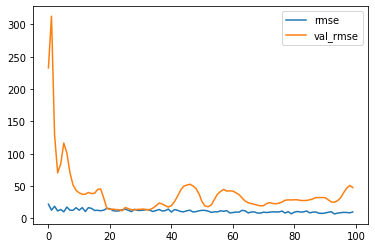

In [17]:
metrics = history.history
plt.plot(history.epoch, np.sqrt(metrics['mean_squared_error']), np.sqrt(metrics['val_mean_squared_error']))
plt.legend(['rmse', 'val_rmse'])
plt.show()

In [18]:
print("Evaluate on test data")
results = model.evaluate(test_x, test_y, batch_size=64)
print("test rmse:", np.sqrt(results)[0])

Evaluate on test data
1/1 [==============================] - 0s 24ms/step - loss: 142.7237 - mean_squared_error: 142.7237
test rmse: 11.946702855032651
